In [1]:
# Configure Spark environment
import os
import sys
 
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, spark_home + "/python")
 
# Add py4j to the path with the version matching the SPARK_HOME/python/lib content
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.9-src.zip'))

try:
    from pyspark import SparkContext
    from pyspark import SparkConf
    print ("Successfully imported Spark Modules")

except ImportError as e:
    print ("Can not import Spark Modules", e)
    sys.exit(1)

Successfully imported Spark Modules


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
limit_rows   = 7000000
df           = pd.read_csv("/home/hugo/Documents/Challenge Datascience/kaggle/Santander Product Recommandation/train_ver2.csv",dtype={"sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str}, nrows=limit_rows)
unique_ids   = pd.Series(df["ncodpers"].unique())
limit_people = 1e4
unique_id    = unique_ids.sample(n=limit_people)
df           = df[df.ncodpers.isin(unique_id)]
df.describe()

/home/hugo/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/hugo/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:2572: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  locs = rs.choice(axis_length, size=n, replace=replace, p=weights)
/home/hugo/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,ncodpers,indrel,tipodom,cod_prov,ind_actividad_cliente,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
count,7.770500e+04,77434.000000,77434.0,76977.000000,77434.000000,6.402400e+04,77705.000000,77705.0,77705.000000,77705.000000,...,77705.000000,77705.000000,77705.000000,77705.000000,77705.000000,77705.000000,77705.000000,77535.000000,77535.000000,77705.000000
mean,8.060876e+05,1.130356,1.0,26.541019,0.489023,1.357759e+05,0.000129,0.0,0.712412,0.000592,...,0.006911,0.009124,0.002818,0.053922,0.046509,0.029367,0.006177,0.055523,0.059947,0.132836
std,4.171522e+05,3.571845,0.0,12.691531,0.499883,2.732125e+05,0.011344,0.0,0.452641,0.024324,...,0.082844,0.095085,0.053014,0.225865,0.210587,0.168835,0.078353,0.229000,0.237390,0.339399
min,1.593600e+04,1.000000,1.0,1.000000,0.000000,2.336010e+03,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.308390e+05,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
50%,9.196720e+05,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
75%,1.164922e+06,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
max,1.495439e+06,99.000000,1.0,52.000000,1.000000,1.326862e+07,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df["fecha_dato"] = pd.to_datetime(df["fecha_dato"],format="%Y-%m-%d")
df["fecha_alta"] = pd.to_datetime(df["fecha_alta"],format="%Y-%m-%d")
df["fecha_dato"].unique()

array(['2015-01-28T00:00:00.000000000', '2015-02-28T00:00:00.000000000',
       '2015-03-28T00:00:00.000000000', '2015-04-28T00:00:00.000000000',
       '2015-05-28T00:00:00.000000000', '2015-06-28T00:00:00.000000000',
       '2015-07-28T00:00:00.000000000', '2015-08-28T00:00:00.000000000',
       '2015-09-28T00:00:00.000000000', '2015-10-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [5]:
df["month"] = pd.DatetimeIndex(df["fecha_dato"]).month
df["age"]   = pd.to_numeric(df["age"], errors="coerce")

In [6]:
df.isnull().any()

fecha_dato               False
ncodpers                 False
ind_empleado              True
pais_residencia           True
sexo                      True
age                       True
fecha_alta                True
ind_nuevo                 True
antiguedad               False
indrel                    True
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                   True
indext                    True
conyuemp                  True
canal_entrada             True
indfall                   True
tipodom                   True
cod_prov                  True
nomprov                   True
ind_actividad_cliente     True
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp

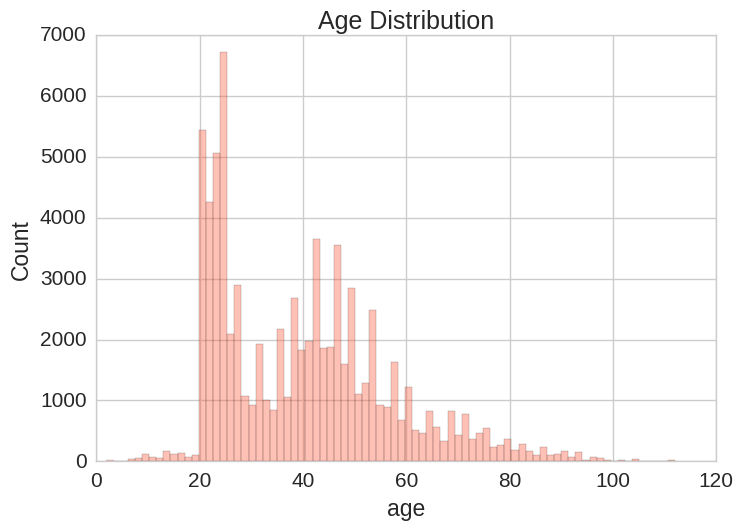

In [11]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df["age"].dropna(),
                 bins=80,
                 kde=False,
                 color="tomato")
    sns.plt.title("Age Distribution")
    plt.ylabel("Count")

In [12]:
df.loc[df.age < 18,"age"]  = df.loc[(df.age >= 18) & (df.age <= 30),"age"].mean(skipna=True)
df.loc[df.age > 100,"age"] = df.loc[(df.age >= 30) & (df.age <= 100),"age"].mean(skipna=True)
df["age"].fillna(df["age"].mean(),inplace=True)
df["age"]                  = df["age"].astype(int)

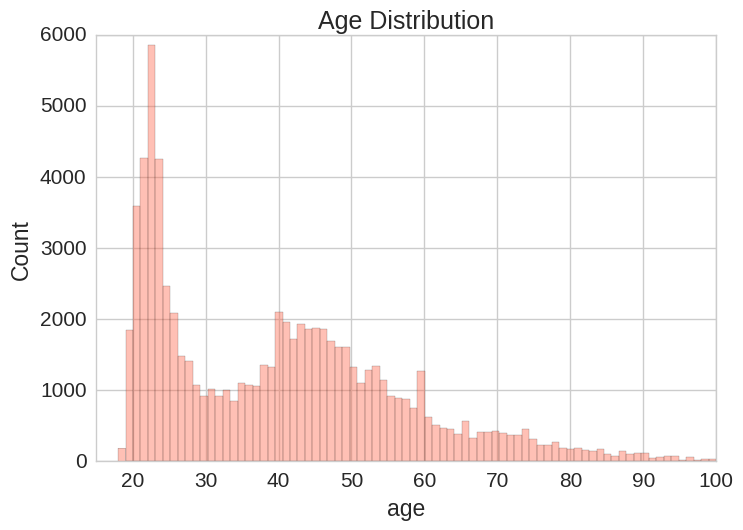

In [13]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df["age"].dropna(),
                 bins=80,
                 kde=False,
                 color="tomato")
    sns.plt.title("Age Distribution")
    plt.ylabel("Count")
    plt.xlim((15,100))

In [14]:
df["ind_nuevo"].isnull().sum()

271

In [15]:
months_active = df.loc[df["ind_nuevo"].isnull(),:].groupby("ncodpers", sort=False).size()
months_active.max()

6

In [16]:
df.loc[df["ind_nuevo"].isnull(),"ind_nuevo"] = 1

In [17]:
df.antiguedad = pd.to_numeric(df.antiguedad,errors="coerce")
np.sum(df["antiguedad"].isnull())

271

In [18]:
df.loc[df["antiguedad"].isnull(),"ind_nuevo"].describe()

count     271
unique      1
top         1
freq      271
Name: ind_nuevo, dtype: int64

In [19]:
df.loc[df.antiguedad.isnull(),"antiguedad"] = df.antiguedad.min()
df.loc[df.antiguedad <0, "antiguedad"]      = 0 # Thanks @StephenSmith for bug-find

In [20]:
dates=df.loc[:,"fecha_alta"].sort_values().reset_index()
median_date = int(np.median(dates.index.values))
df.loc[df.fecha_alta.isnull(),"fecha_alta"] = dates.loc[median_date,"fecha_alta"]
df["fecha_alta"].describe()

count                   77705
unique                   3642
top       2014-07-28 00:00:00
freq                      416
first     1995-02-02 00:00:00
last      2015-10-30 00:00:00
Name: fecha_alta, dtype: object

In [21]:
pd.Series([i for i in df.indrel]).value_counts()

1.0     77331
99.0      103
dtype: int64

In [22]:
df.loc[df.indrel.isnull(),"indrel"] = 1

In [23]:
df.drop(["tipodom","cod_prov"],axis=1,inplace=True)

In [24]:
df.isnull().any()

fecha_dato               False
ncodpers                 False
ind_empleado              True
pais_residencia           True
sexo                      True
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                   True
indext                    True
conyuemp                  True
canal_entrada             True
indfall                   True
nomprov                   True
ind_actividad_cliente     True
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco_fin_ult1        False
ind_deme

In [25]:
np.sum(df["ind_actividad_cliente"].isnull())

271

In [26]:
df.loc[df.ind_actividad_cliente.isnull(),"ind_actividad_cliente"] = \
df["ind_actividad_cliente"].median()

In [28]:
df.nomprov.unique()

array(['BARCELONA', 'GIPUZKOA', 'CORU\xc3\x91A, A', 'PALENCIA', 'TOLEDO',
       'LUGO', 'CUENCA', 'VALENCIA', 'ZARAGOZA', 'MADRID', 'CACERES',
       'ALICANTE', 'LERIDA', 'TARRAGONA', 'SALAMANCA', 'RIOJA, LA',
       'PONTEVEDRA', 'SEVILLA', 'HUELVA', 'BURGOS', 'MALAGA',
       'PALMAS, LAS', 'BADAJOZ', 'GRANADA', 'OURENSE', 'ALBACETE',
       'VALLADOLID', 'ZAMORA', 'CADIZ', 'SEGOVIA', 'ASTURIAS', 'LEON',
       'CIUDAD REAL', 'CORDOBA', 'GIRONA', 'BALEARS, ILLES', 'CANTABRIA',
       'CASTELLON', 'HUESCA', 'MURCIA', nan, 'NAVARRA', 'GUADALAJARA',
       'SANTA CRUZ DE TENERIFE', 'JAEN', 'BIZKAIA', 'CEUTA', 'SORIA',
       'AVILA', 'ALMERIA', 'TERUEL', 'ALAVA', 'MELILLA'], dtype=object)

In [29]:
df.loc[df.nomprov=="CORU\xc3\x91A, A","nomprov"] = "CORUNA, A"

In [30]:
df.loc[df.nomprov.isnull(),"nomprov"] = "UNKNOWN"

In [31]:
#df.loc[df.renta.notnull(),:].groupby("nomprov").agg([{"Sum":sum},{"Mean":mean}])
incomes = df.loc[df.renta.notnull(),:].groupby("nomprov").agg({"renta":{"MedianIncome":median}})
incomes.sort_values(by=("renta","MedianIncome"),inplace=True)
incomes.reset_index(inplace=True)
incomes.nomprov = incomes.nomprov.astype("category", categories=[i for i in df.nomprov.unique()],ordered=False)
incomes.head()

,nomprov,renta
,,MedianIncome
0,JAEN,59382.06
1,CACERES,63855.00
2,CUENCA,65851.98
3,ZAMORA,66583.98
4,ALICANTE,66785.79


([<matplotlib.axis.YTick at 0x7fb43a2bfad0>,
 <a list of 5 Text yticklabel objects>)

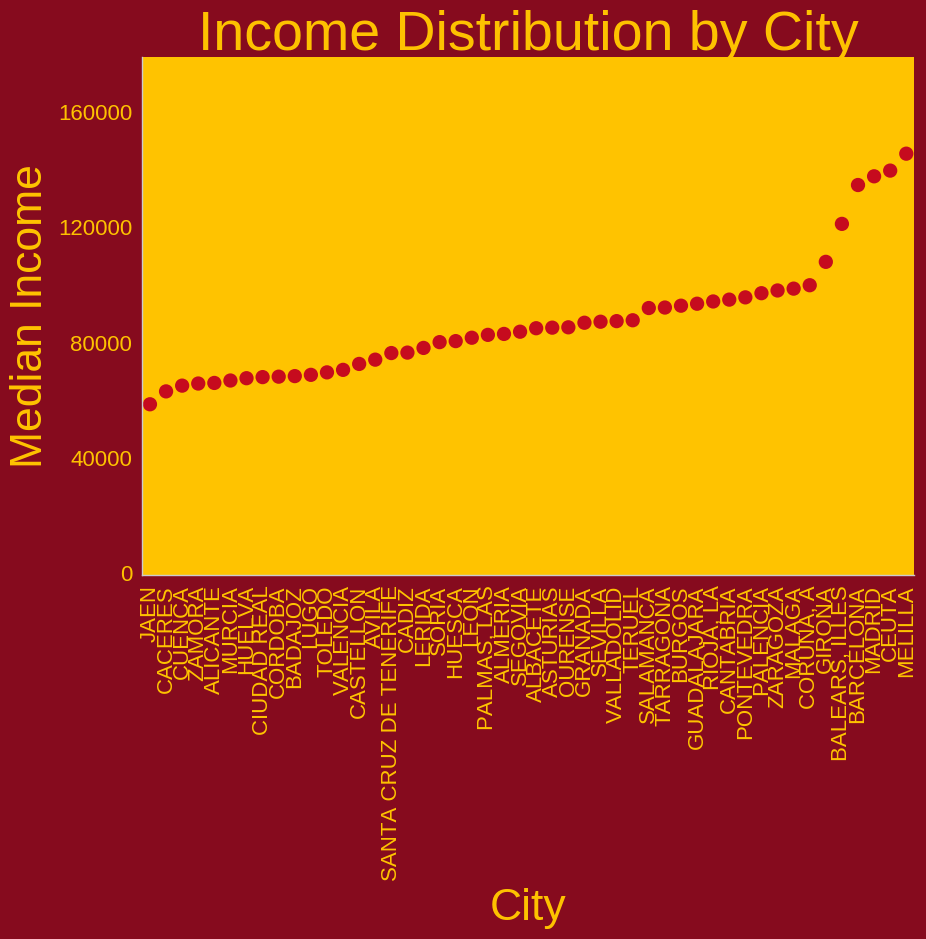

In [36]:
with sns.axes_style({
        "axes.facecolor":   "#ffc300",
        "axes.grid"     :    False,
        "figure.facecolor": "#860b1e"}):
    h = sns.factorplot(data=incomes,
                   x="nomprov",
                   y=("renta","MedianIncome"),
                   order=(i for i in incomes.nomprov),
                   size=6,
                   aspect=1.5,
                   scale=1.0,
                   color="#c60b1e",
                   linestyles="None")
plt.xticks(rotation=90)
plt.tick_params(labelsize=16,labelcolor="#ffc400")#
plt.ylabel("Median Income",size=32,color="#ffc400")
plt.xlabel("City",size=32,color="#ffc400")
plt.title("Income Distribution by City",size=40,color="#ffc400")
plt.ylim(0,180000)
plt.yticks(range(0,180000,40000))

In [33]:
grouped        = df.groupby("nomprov").agg({"renta":lambda x: x.median(skipna=True)}).reset_index()
new_incomes    = pd.merge(df,grouped,how="inner",on="nomprov").loc[:, ["nomprov","renta_y"]]
new_incomes    = new_incomes.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("nomprov")
df.sort_values("nomprov",inplace=True)
df             = df.reset_index()
new_incomes    = new_incomes.reset_index()

In [37]:
df.loc[df.renta.isnull(),"renta"] = new_incomes.loc[df.renta.isnull(),"renta"].reset_index()
df.loc[df.renta.isnull(),"renta"] = df.loc[df.renta.notnull(),"renta"].median()
df.sort_values(by="fecha_dato",inplace=True)

In [38]:
df.ind_nomina_ult1.isnull().sum()

170

In [39]:
df.loc[df.ind_nomina_ult1.isnull(), "ind_nomina_ult1"] = 0
df.loc[df.ind_nom_pens_ult1.isnull(), "ind_nom_pens_ult1"] = 0

In [40]:
string_data = df.select_dtypes(include=["object"])
missing_columns = [col for col in string_data if string_data[col].isnull().any()]
for col in missing_columns:
    print("Unique values for {0}:\n{1}\n".format(col,string_data[col].unique()))
del string_data

Unique values for ind_empleado:
['N' nan 'B' 'A' 'F']

Unique values for pais_residencia:
['ES' nan 'CH' 'US' 'TH' 'PE' 'AR' 'BE' 'ET' 'DE' 'PY' 'MA' 'MX' 'PL' 'BR'
 'CO' 'EC' 'GB' 'FR' 'VE' 'IT' 'PK' 'CU' 'RO' 'EG' 'AU' 'IL' 'TR' 'SE']

Unique values for sexo:
['H' 'V' nan]

Unique values for ult_fec_cli_1t:
[nan '2015-07-13' '2015-07-16' '2015-07-09' '2015-07-02' '2015-07-01'
 '2015-07-22' '2015-07-08' '2015-07-06' '2015-07-17' '2015-07-10'
 '2015-08-24' '2015-08-06' '2015-08-05' '2015-08-10' '2015-08-03'
 '2015-08-27' '2015-08-18' '2015-08-04' '2015-09-15' '2015-09-04'
 '2015-09-25' '2015-09-07' '2015-09-18' '2015-09-01' '2015-09-24'
 '2015-09-08' '2015-09-03' '2015-09-29' '2015-09-11' '2015-09-14'
 '2015-09-17' '2015-09-22' '2015-09-09' '2015-10-23' '2015-10-26'
 '2015-10-13' '2015-10-29' '2015-10-07' '2015-10-21' '2015-10-06'
 '2015-10-16' '2015-10-05' '2015-10-14' '2015-10-19' '2015-10-28']

Unique values for indrel_1mes:
[1.0 nan '1.0' '1' 3.0 'P' '2.0' '3.0' '3' 2.0 '2']

Uniqu

In [41]:
df.loc[df.indfall.isnull(),"indfall"] = "N"
df.loc[df.tiprel_1mes.isnull(),"tiprel_1mes"] = "A"
df.tiprel_1mes = df.tiprel_1mes.astype("category")

# As suggested by @StephenSmith
map_dict = { 1.0  : "1",
            "1.0" : "1",
            "1"   : "1",
            "3.0" : "3",
            "P"   : "P",
            3.0   : "3",
            2.0   : "2",
            "3"   : "3",
            "2.0" : "2",
            "4.0" : "4",
            "4"   : "4",
            "2"   : "2"}

df.indrel_1mes.fillna("P",inplace=True)
df.indrel_1mes = df.indrel_1mes.apply(lambda x: map_dict.get(x,x))
df.indrel_1mes = df.indrel_1mes.astype("category")


unknown_cols = [col for col in missing_columns if col not in ["indfall","tiprel_1mes","indrel_1mes"]]
for col in unknown_cols:
    df.loc[df[col].isnull(),col] = "UNKNOWN"


In [42]:
df.isnull().any()

index                    False
fecha_dato               False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                     False
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
ult_fec_cli_1t           False
indrel_1mes              False
tiprel_1mes              False
indresi                  False
indext                   False
conyuemp                 False
canal_entrada            False
indfall                  False
nomprov                  False
ind_actividad_cliente    False
renta                    False
segmento                 False
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco

In [43]:
feature_cols = df.iloc[:1,].filter(regex="ind_+.*ult.*").columns.values
for col in feature_cols:
    df[col] = df[col].astype(int)

In [44]:
unique_months = pd.DataFrame(pd.Series(df.fecha_dato.unique()).sort_values()).reset_index(drop=True)
unique_months["month_id"] = pd.Series(range(1,1+unique_months.size)) # start with month 1, not 0 to match what we already have
unique_months["month_next_id"] = 1 + unique_months["month_id"]
unique_months.rename(columns={0:"fecha_dato"},inplace=True)
df = pd.merge(df,unique_months,on="fecha_dato")

In [45]:
def status_change(x):
    diffs = x.diff().fillna(0)# first occurrence will be considered Maintained, 
    #which is a little lazy. A better way would be to check if 
    #the earliest date was the same as the earliest we have in the dataset
    #and consider those separately. Entries with earliest dates later than that have 
    #joined and should be labeled as "Added"
    label = ["Added" if i==1 \
         else "Dropped" if i==-1 \
         else "Maintained" for i in diffs]
    return label

In [46]:
# df.loc[:, feature_cols] = df..groupby("ncodpers").apply(status_change)
df.loc[:, feature_cols] = df.loc[:, [i for i in feature_cols]+["ncodpers"]].groupby("ncodpers").transform(status_change)

In [47]:
df = pd.melt(df, id_vars   = [col for col in df.columns if col not in feature_cols],
            value_vars= [col for col in feature_cols])
df = df.loc[df.value!="Maintained",:]
df.shape

(6359, 28)

([<matplotlib.axis.YTick at 0x7fb43a48a090>,
 <a list of 5 Text yticklabel objects>)

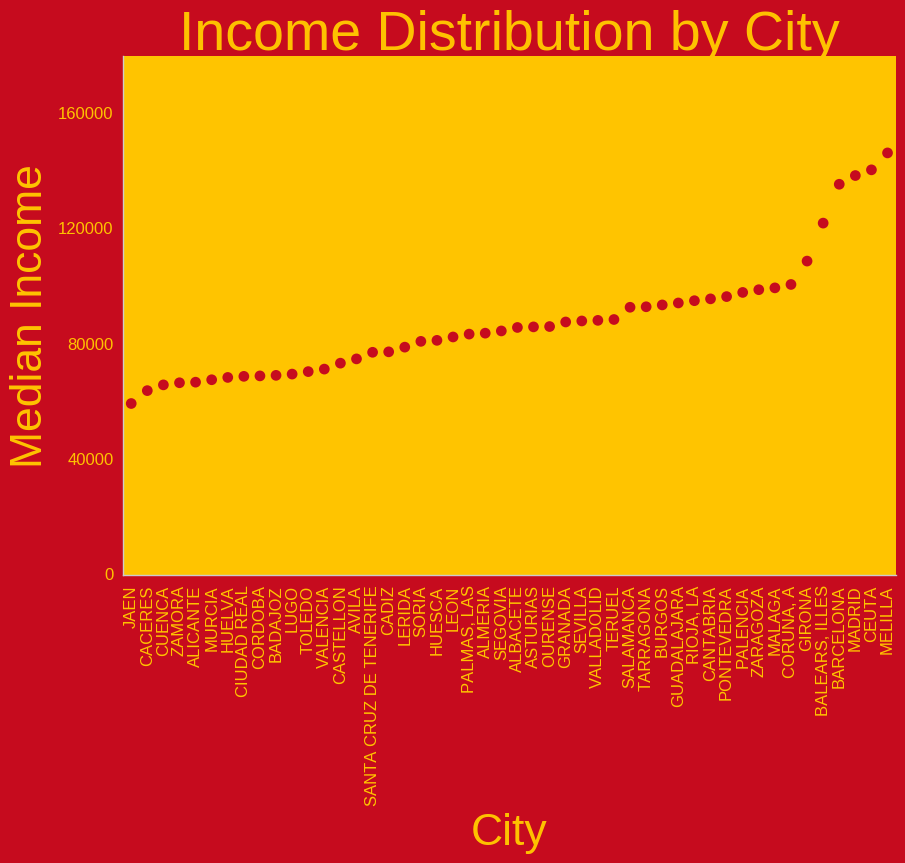

In [48]:
# For thumbnail
pylab.rcParams['figure.figsize'] = (6, 4)
with sns.axes_style({
        "axes.facecolor":   "#ffc400",
        "axes.grid"     :    False,
        "figure.facecolor": "#c60b1e"}):
    h = sns.factorplot(data=incomes,
                   x="nomprov",
                   y=("renta","MedianIncome"),
                   order=(i for i in incomes.nomprov),
                   size=6,
                   aspect=1.5,
                   scale=0.75,
                   color="#c60b1e",
                   linestyles="None")
plt.xticks(rotation=90)
plt.tick_params(labelsize=12,labelcolor="#ffc400")#
plt.ylabel("Median Income",size=32,color="#ffc400")
plt.xlabel("City",size=32,color="#ffc400")
plt.title("Income Distribution by City",size=40,color="#ffc400")
plt.ylim(0,180000)
plt.yticks(range(0,180000,40000))